# Digit generation with Restricted Boltzmann Machines in NumPy

In [1]:
import mnist
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

%matplotlib inline
np.random.seed(67)

In [2]:
print(f'sys.version: {sys.version}')

sys.version: 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]


## 1. Load MNIST

In [3]:
X_train = mnist.train_images().reshape(-1, 28 * 28) / 255.
y_train = mnist.train_labels()

print(f'X_train: dtype={X_train.dtype}, shape={X_train.shape}, min_max=[{X_train.min()}, {X_train.max()}]')
print(f'y_train: dtype={y_train.dtype}, shape={y_train.shape}, min_max=[{y_train.min()}, {y_train.max()}]')

X_train: dtype=float64, shape=(60000, 784), min_max=[0.0, 1.0]
y_train: dtype=uint8, shape=(60000,), min_max=[0, 9]


__Look at some images__

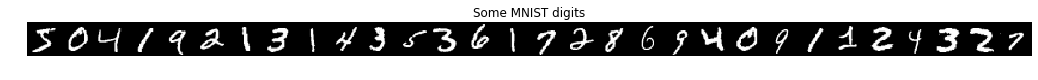

In [4]:
concat_imgs = np.concatenate(tuple(X_train[idx].reshape(28, 28) for idx in range(30)), axis=1)
plt.figure(figsize=(18, 9))
plt.imshow(concat_imgs, cmap='gray')
plt.axis('off')
plt.title('Some MNIST digits')
plt.show()

__Compute prop_on[:, i] - the proportion of training vectors in which unit *i* is on. These values will be used to initialize biases for visible units.__  
[A Practical Guide to Training Restricted Boltzmann Machines (Hinton, 2010)](http://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)

prop_on.shape: (784,)


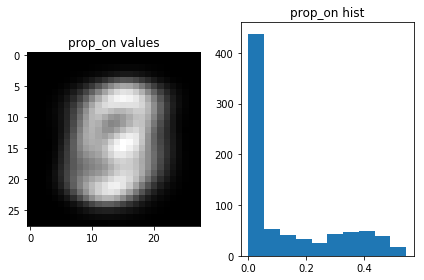

In [5]:
prop_on = np.mean(X_train, axis=0)
print(f'prop_on.shape: {prop_on.shape}')

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(prop_on.reshape(28, 28), cmap='gray')
plt.title('prop_on values')

plt.subplot(1, 2, 2)
plt.hist(prop_on)
plt.title('prop_on hist')
plt.tight_layout()
plt.show()

## 2. RBM

In [6]:
# aux functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def norm_img(img):
    img_min = img.min()
    img_max = img.max()
    img_norm = (img - img_min) / (img_max - img_min)
    return img_norm

In [7]:
class RBM:
    def __init__(self, vis_dim=784, hidden_dim=200, training_method='cd', prop_on=None):
        # init hidden layer
        self.h = np.zeros(hidden_dim)
        self.h_bias = np.zeros(hidden_dim)
        
        # init visible layer
        self.v_bias = np.zeros(vis_dim)
        if prop_on is not None:
            # added 1e-20 for numerical stability
            self.c = np.log((1e-20 + prop_on) / (1e-20 + 1 - prop_on))
        
        # prepare params for training
        self.training_method = training_method
        self.w = 1e-2 * np.random.randn(hidden_dim, vis_dim)
        self.lr = 1e-2
    
    
    def h_prob(self, v):
        return sigmoid(np.dot(self.w, v.T) + self.h_bias[:, None])
    
    
    def up_vh(self, v):
        h_prob = sigmoid(np.dot(self.w, v.T) + self.h_bias[:, None])
        self.h = h_prob > np.random.uniform(0, 1, h_prob.shape)
    
    
    def down_hv(self):
        v_prob = sigmoid(np.dot(self.h.T, self.w) + self.v_bias[None, :])
        v = v_prob > np.random.uniform(0, 1, v_prob.shape)
        return v
    
    
    def gibbs_sampling(self, v, k):
        for _ in range(k):
            self.up_vh(v)
            v = self.down_hv()
        return v
    
    
    def train(self, X, epochs=5, batch_size=32, gibbs_sampling_steps=1):
        N = X.shape[0]
        start_indices = list(range(0, N, batch_size))
        end_indices = list(range(batch_size, N, batch_size))
        if end_indices[-1] != N:
            end_indices.append(N)
        
        train_evolution = {}
        train_evolution[0] = {}
        train_evolution[0]['img'] = X_train[:10].copy()
        train_evolution[0]['w'] = self.w.copy()
        
        for epoch in tqdm(range(epochs)):
            x_neg_sample = None
            for (start_idx, end_idx) in zip(start_indices, end_indices):
                # gibbs sampling
                x0 = X_train[start_idx:end_idx]
                x_neg_sample = self.gibbs_sampling(x0, gibbs_sampling_steps)
                
                # update weights and biases
                self.w += self.lr * (np.dot(self.h_prob(x0), x0)
                                     - 
                                     np.dot(self.h_prob(x_neg_sample), x_neg_sample))
                self.h_bias += self.lr * np.mean(self.h_prob(x0) - self.h_prob(x_neg_sample), axis=1)
                self.v_bias += self.lr * np.mean(x0 - x_neg_sample, axis=0)
            
            # save neg samples and weights for every epoch
            train_evolution[epoch + 1] = {}
            train_evolution[epoch + 1]['img'] = self.gibbs_sampling(X_train[:10], gibbs_sampling_steps)
            train_evolution[epoch + 1]['w'] = self.w.copy()
            
        return train_evolution

In [8]:
EPOCHS = 15
BATCH_SIZE = 32
GIBBS_SAMPLING_STEPS = 1
HIDDEN_DIM = 200

rbm = RBM(hidden_dim=HIDDEN_DIM, 
          prop_on=prop_on,
          training_method='cd')

train_evolution = rbm.train(X_train, 
                            epochs=EPOCHS, 
                            batch_size=BATCH_SIZE,
                            gibbs_sampling_steps=GIBBS_SAMPLING_STEPS)

100%|██████████| 15/15 [03:06<00:00, 12.65s/it]


__Look at some reconstructed images during training__

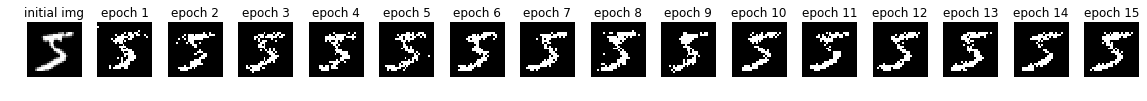

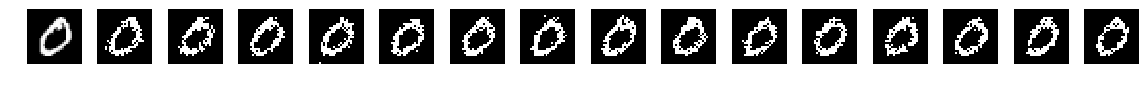

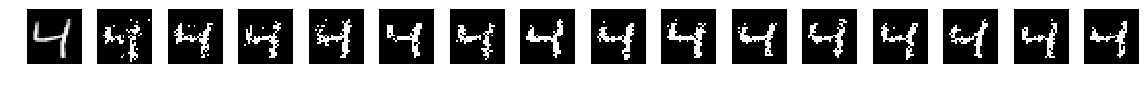

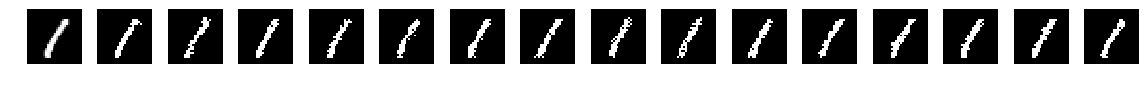

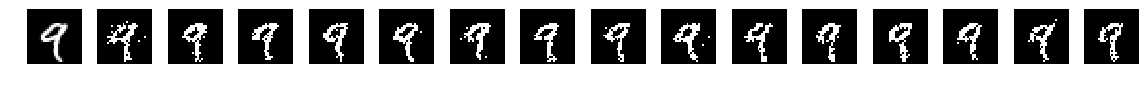

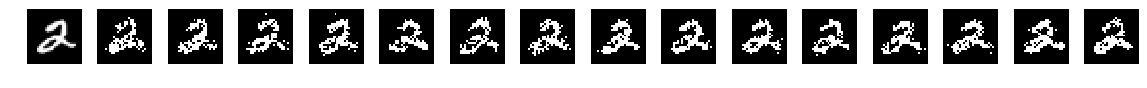

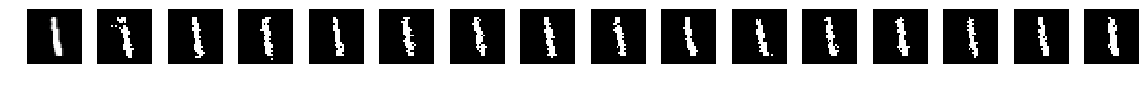

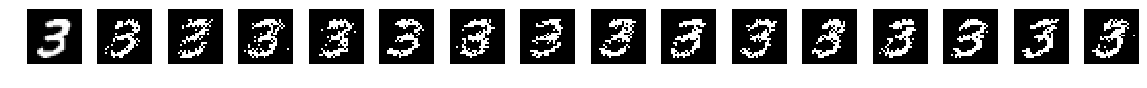

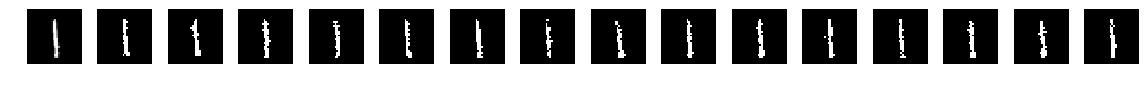

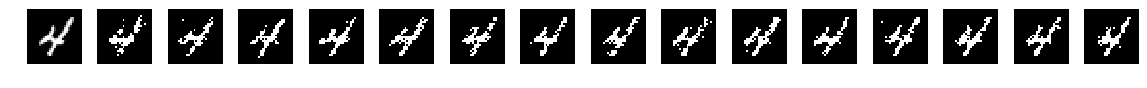

In [9]:
for img_idx in range(10):
    plt.figure(figsize=(20, 1))
    subplot_idx = 0
    for epoch in sorted(train_evolution.keys()):
        subplot_idx += 1
        plt.subplot(1, EPOCHS + 1, subplot_idx)
        plt.imshow(train_evolution[epoch]['img'][img_idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if img_idx == 0 and epoch == 0:
            plt.title('initial img')
        elif img_idx == 0:
            plt.title(f'epoch {epoch}')

__Look at the weights during training__

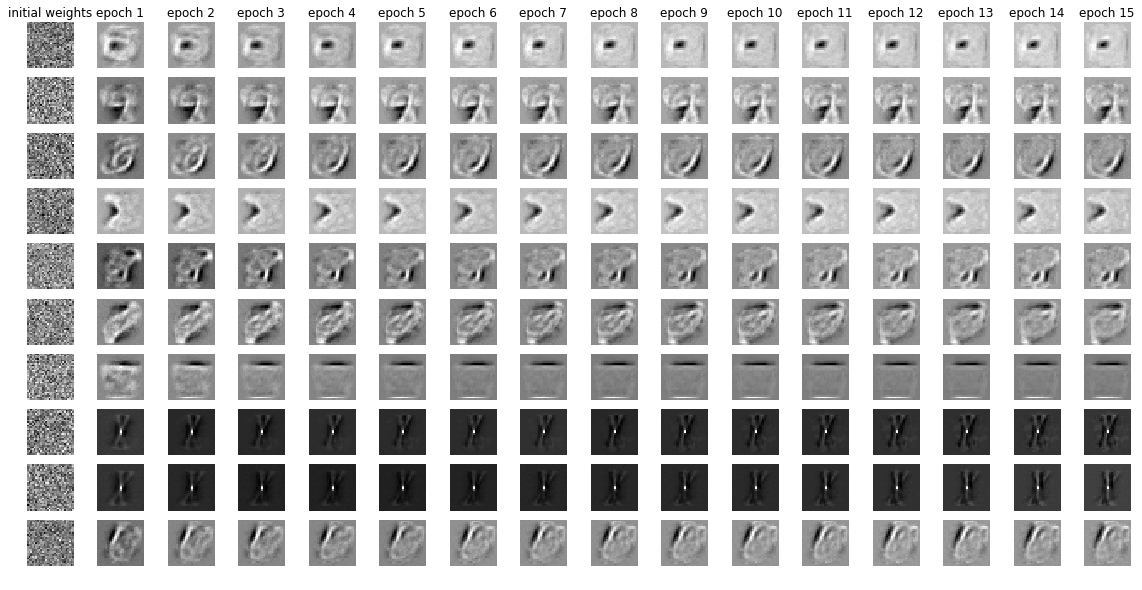

In [10]:
plt.figure(figsize=(20, 10))
subplot_idx = 0
for w_idx in range(10):
    for epoch in sorted(train_evolution.keys()):
        subplot_idx += 1
        plt.subplot(10, EPOCHS + 1, subplot_idx)
        w_norm = norm_img(train_evolution[epoch]['w'][w_idx].reshape(28, 28))
        plt.imshow(w_norm, cmap='gray')
        plt.axis('off')
        if w_idx == 0:
            if epoch == 0:
                plt.title(f'initial weights')
            else:
                plt.title(f'epoch {epoch}')

__Look at the final weights__

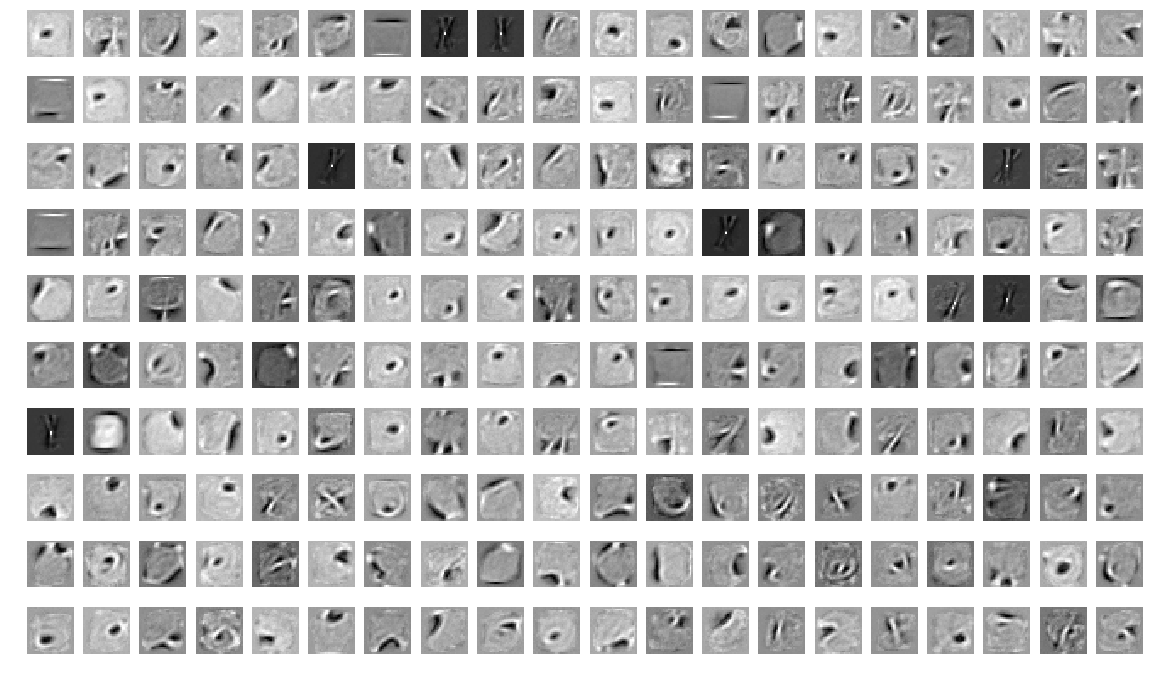

In [11]:
plt.figure(figsize=(20, 12))
subplot_idx = 0
for w_idx in range(HIDDEN_DIM):
    subplot_idx += 1
    plt.subplot(HIDDEN_DIM // 20, 20, subplot_idx)
    w_norm = norm_img(train_evolution[EPOCHS - 1]['w'][w_idx].reshape(28, 28))
    plt.imshow(w_norm, cmap='gray')
    plt.axis('off')